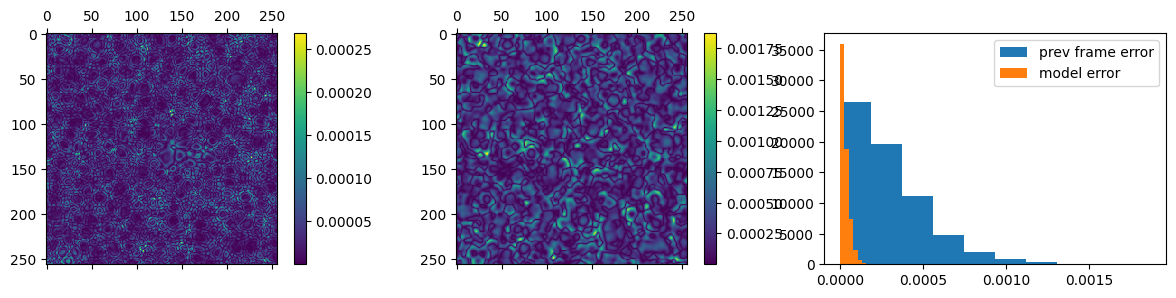

In [495]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda"
torch.set_grad_enabled(False)
torch.set_default_device(device)

def pad(X, axis, extent, mode="circular", val_left=None, val_right=None):
    X = X.transpose(axis, -1)

    if mode == "circular":
        assert extent <= X.shape[-1]
        left, right = X[...,-extent:], X[...,:extent]
    elif mode == "dirichlet": 
        shape = list(X.shape[:-1]) + [extent]
        left, right = torch.ones(shape)*val_left, torch.ones(shape)*val_right
    else:
        raise Exception

    X = torch.cat((left, X, right), dim=-1)
    X = X.transpose(axis, -1)
    return X

def unpad(X, axis, extent): # removes padding from axis
    X = X.transpose(axis, -1)
    X = X[...,extent:-extent]
    X = X.transpose(axis, -1)
    return X

# compares steerable with non-steerable kernels
def make_invariant_kernels(n, ks):
    coordinates = torch.linspace(-1,1,ks)
    coordinates = torch.meshgrid((coordinates,coordinates), indexing="xy")
    coordinates = torch.stack(coordinates, dim=0)
    radius = coordinates.pow(2).sum(dim=0).sqrt()
    # theta = torch.atan2(coordinates[1,...],coordinates[0,...])
    unique_radii = radius.unique() 
    # unique_thetas = theta.unique()

    # theta_values = 2*torch.rand((n, *unique_thetas.shape))-1
    radius_values = torch.empty((n,*unique_radii.shape)) # 2*torch.rand((n, *unique_radii.shape))-1
    torch.nn.init.normal_(radius_values)
    # kernels_theta = torch.zeros((n,ks,ks))
    kernels_rad = torch.zeros((n,ks,ks))

    # for idx, t in enumerate(unique_thetas): kernels_theta[:,theta == t] = theta_values[:,None,idx]
    for idx, r in enumerate(unique_radii): kernels_rad[:,radius == r] = radius_values[:,None,idx]
    # kernels = kernels_theta * kernels_rad
    return kernels_rad

class PointwiseLinear(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layer = torch.nn.Linear(in_dim, out_dim, bias=False).double()

    def forward(self, X):
        X = X.transpose(1,-1) # shifts the channel axis to the last index
        Y = self.layer(X)
        Y = Y.transpose(1,-1)
        return Y

    def train(self, X, Y):
        X = X.transpose(1,-1) # shifts the channel axis to the last index
        X = X.reshape(-1,X.shape[-1]) # conflates the first few axes, except for input dimension
        Y = Y.transpose(1,-1).reshape(-1, 1) # shifts the channel axis to the last index
        A = torch.linalg.lstsq(X.cpu(), Y.cpu(), driver="gelsd", rcond=1e-8).solution.transpose(0,1)
        # A = torch.linalg.lstsq(X, Y, rcond=1e-2).solution.transpose(0,1)
        self.layer.weight.data = A.to(device)

class FiniteDifferenceLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # hard-coded finite-difference kernels
        # dx = torch.tensor([1/280, -4/105, 1/5, -4/5, 0, 4/5, -1/5, 4/105, -1/280 ]).double()
        # dxx = torch.tensor([-1/560, 8/315, -1/5, 8/5, -205/72, 8/5, -1/5, 8/315, -1/560 ]).double()
        # dxxxx = torch.tensor([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240 ]).double()
        # dxx = torch.tensor([-1/12, 4/3, -5/2, 4/3, -1/12]).double()
        # dxx = torch.tensor([1, -2, 1]).double()

        self.extent = 1
        self.ks = 2*self.extent + 1 # dxx.shape[0]
        self.nr_kernels = 2
        # self.conv_dx = torch.nn.Conv1d(1, 1, self.ks, bias=False).double()
        # self.conv_dx.weight.data = dx.view(1,1,self.ks)
        # self.conv_dxx = torch.nn.Conv1d(1, 1, self.ks, bias=False).double()

        self.conv1d = torch.nn.Conv1d(self.nr_kernels, self.nr_kernels, self.ks, groups=self.nr_kernels, bias=False).double()
        self.conv2d = torch.nn.Conv2d(self.nr_kernels, self.nr_kernels, self.ks, groups=self.nr_kernels, bias=False).double()

        # print( self.conv2d.weight.data.shape )
        # self.conv2d.weight.data = make_invariant_kernels(self.channels, self.ks).unsqueeze(1).double()

        # laplace1d = torch.tensor([-1/12, 4/3, -5/2, 4/3, -1/12]).double()
        laplace1d = torch.tensor([1, -2, 1]).double()
        identity1d = torch.tensor([0,1,0]).double()
        self.conv1d.weight.data[0,0,:] = laplace1d
        self.conv1d.weight.data[1,0,:] = identity1d

        # laplace2d = torch.tensor([[0,0,0,0,0],[0,0,1,0,0],[0,1,-4,1,0],[0,0,1,0,0],[0,0,0,0,0]]).double()
        # laplace2d = torch.tensor([
        #     [ 0.048,  0.328,  0.436,  0.328,  0.048],
        #     [ 0.328, -0.3  , -0.54 , -0.3  ,  0.328],
        #     [ 0.436, -0.54 , -1.2  , -0.54 ,  0.436],
        #     [ 0.328, -0.3  , -0.54 , -0.3  ,  0.328],
        #     [ 0.048,  0.328,  0.436,  0.328,  0.048]])
        # identity2d = torch.tensor([
        #     [0,0,0,0,0],
        #     [0,0,0,0,0],
        #     [0,0,1,0,0],
        #     [0,0,0,0,0],
        #     [0,0,0,0,0]]).double()
        # laplace2d = torch.tensor([
        #     [ 0.107,  0.241,  0.107],
        #     [ 0.241, -1.39,   0.241],
        #     [ 0.107,  0.241,  0.107]])
        laplace2d = torch.tensor([[1,2,1],[2,-12,2],[1,2,1]]).double() / 4
        identity2d = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).double()
        self.conv2d.weight.data[0,0,:,:] = laplace2d
        self.conv2d.weight.data[1,0,:,:] = identity2d

    def forward(self, X):
        # X has shape: batch x channels x dim1 x dim2 x ...
        # computes a vector of size batch x channels x dim1 x dim2 x ...
        dims_shape = X.shape[2:]
        nr_dims = len(dims_shape)
        new_dims_shape = torch.tensor(dims_shape) - 2*self.extent

        assert nr_dims in [1,2], "other dimension sizes not yet implemented"

        orig_channels = X.shape[1]
        assert orig_channels % self.nr_kernels == 0

        X = X.view(-1, self.nr_kernels, *dims_shape)
        if nr_dims == 1: X = self.conv1d(X)
        if nr_dims == 2: X = self.conv2d(X)
        X = X.view(-1, orig_channels, *new_dims_shape)
        return X
    
class Model(torch.nn.Module):
    def __init__(self, out1=8, out2=16, hidden=32, bc=None):
        super().__init__()
        self.out1 = out1 
        self.out2 = out2 
        self.hidden = hidden
        self.bc = bc

        self.nl = torch.nn.Softplus()
        self.block1 = torch.nn.Sequential(
            FiniteDifferenceLayer(),
            PointwiseLinear(self.out1, self.out2),
            self.nl
        )
        self.block2 = torch.nn.Sequential(
            FiniteDifferenceLayer(),
            PointwiseLinear(self.out2, self.hidden),
            self.nl
        )

        self.lin_out = PointwiseLinear(self.hidden, 1)
        self.extent = self.block1[0].extent + self.block2[0].extent

    def pad(self, X):
        for i in range(len(X.shape)-1): 
            X = pad(X, axis=i+1, extent=self.extent, **self.bc[i])
        return X

    def phi(self, X):
        # X has shape: batch x dim1 x dim2 x ...
        X = self.pad(X)
        X = X.unsqueeze(1)
        X = X.repeat(1, self.out1, *[1]*len(X.shape[2:]))
        X = self.block1(X)
        X = self.block2(X)
        return X

    def forward(self, X):
        return self.lin_out(self.phi(X)).squeeze(1)

    def train(self, X, Y):
        self.lin_out.train(self.phi(X), Y)


D = torch.tensor(np.load("../ks2d/ks2d_short.npy"))
maxval, minval = D.max(), D.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
D = normalize(D)
         
# boundary conditions used in training data
BC_0 = { "mode": "circular", "val_left": None, "val_right": None }
BC_1 = { "mode": "circular", "val_left": None, "val_right": None }

k = 1
X, Y = D[0,None,...], D[k,None,...]
X_noisy = X + torch.distributions.Normal(0, 1e-5).sample(X.shape) 
Y_noisy = Y # + torch.distributions.Normal(0, 1e-3).sample(Y.shape) 
# model = Model(bc=[BC_0, BC_1])
# model.train(X,Y)
# model.train(X_noisy - X_noisy.mean(dim=[1,2]), Y_noisy - X_noisy)
# model.train(X_noisy, Y_noisy - X_noisy)
def f(X): 
    dims = list(range(1,len(X.shape)))
    Y = X + model( X - X.mean(dim=dims) )
    Y = X.mean(dims) + Y - Y.mean(dims)
    return Y

err = (f(X) - D[k,None,:,:])[0,:,:].abs().cpu()
# err = (X + model(X) - D[k,None,:,:])[0,:,:].abs().cpu()
prev_frame_error = (X - D[k,None,:,:])[0,:,:].abs().cpu()

fig, ax = plt.subplots(1,3,figsize=(15,3))
plt.colorbar(ax[0].matshow(err))
plt.colorbar(ax[1].matshow(prev_frame_error))
ax[2].hist(prev_frame_error.flatten(),label="prev frame error")
ax[2].hist(err.flatten(), label="model error")
ax[2].legend()
plt.show()

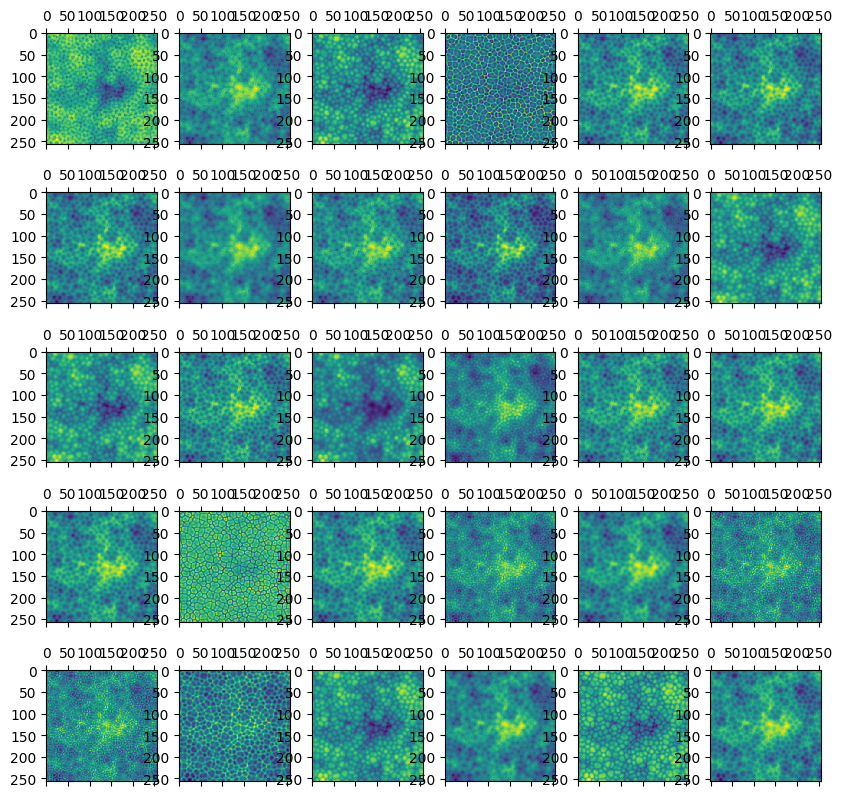

In [475]:
%matplotlib inline
# %matplotlib qt
lenx = int((model.hidden)**0.5)
leny = int( model.hidden/ lenx + 0.5)
fig, ax = plt.subplots(lenx, leny, figsize=(10,10), squeeze=False)
for i in range(lenx):
    for j in range(leny):
        ax[i][j].matshow( model.phi(X - X.mean(dim=[1,2]))[0,i*lenx+j,:,:].cpu().numpy() )
        # ax[i][j].matshow( model.phi(X)[0,i*lenx+j,:,:].cpu().numpy() )
plt.show()

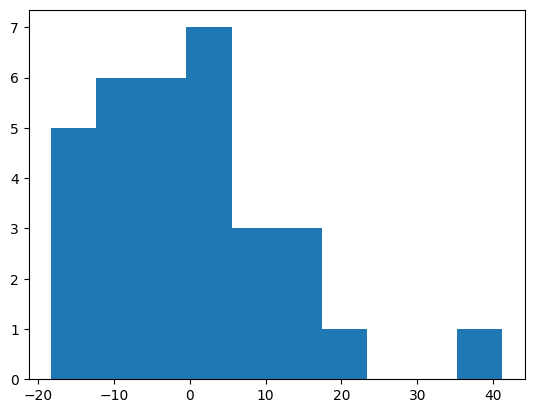

In [496]:
plt.hist(model.lin_out.layer.weight.data.flatten().cpu())
plt.show()

0.0
0.0006757446154423974
0.001349774168173834
0.0020225836737124414
0.0026940983254761797
0.003364103813801478
0.004032382318632788
0.004698746468305259
0.005363041603473229
0.006025140127963624


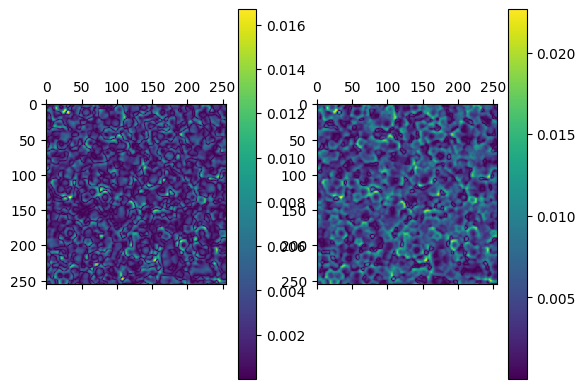

In [497]:
Xs = [ X ]
# n_plots = D.shape[0]
# fig, ax = plt.subplots(3,n_plots,figsize=(20,6))
for i in range(D.shape[0]): 
    # ax[0][i].matshow(Xs[i][0,:,:].cpu(),vmax=1,vmin=0)
    # ax[1][i].matshow(D[i,:,:].cpu(),vmax=1,vmin=0)
    err = (D[i,:,:] - Xs[i][0,:,:]).abs().cpu()
    # ax[2][i].matshow(err)
    print(err.max().item())
    Xs.append(Xs[i] + model(Xs[i] - Xs[i].mean(dim=[1,2])))
    # Xs.append(Xs[i] + model(Xs[i]))
# plt.show()

fig, ax = plt.subplots(1,2)
plt.colorbar(ax[0].matshow( (D[0,...]-D[-1,...]).abs().cpu() ))
plt.colorbar(ax[1].matshow( (Xs[0][0,...]-Xs[-1][0,...]).abs().cpu() ))
plt.show()

In [499]:
# enjoy a nice animation
import itertools
%matplotlib qt
torch.set_grad_enabled(False)

# Dirichlet boundary conditions
# BC_0 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # vertical axis
# BC_1 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # horizontal axis
# model.bc = [BC_0, BC_1]
# 
# # fit initial condition to the boundary conditions, i.e., smoothly transition
# # boundary values to 0
# T = X
# z = torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T)
# z = z * torch.sin(torch.linspace(0,torch.pi,X.shape[2])).expand_as(T).transpose(2,3)
# T = T * z
T = X

im = plt.matshow(T[0,...].cpu().numpy(), vmin=0, vmax=1)
model_fast = model.to(torch.float32).to(device)
T_fast = T.to(torch.float32).to(device)
energy = T_fast.mean()
for j in itertools.count():
    T_fast = T_fast + model_fast(T_fast - T_fast.mean(dim=[1,2]))
    # T_fast = T_fast + model_fast(T_fast)
    # time.sleep(.1)
    T_fast = energy + T_fast - T_fast.mean() # normalizes energy level
    if j % 20 == 0:
        im.set_data(T_fast[0,...].cpu().numpy())
        plt.pause(0.000001)
        plt.draw()
        # print("x")
        # input()

KeyboardInterrupt: 

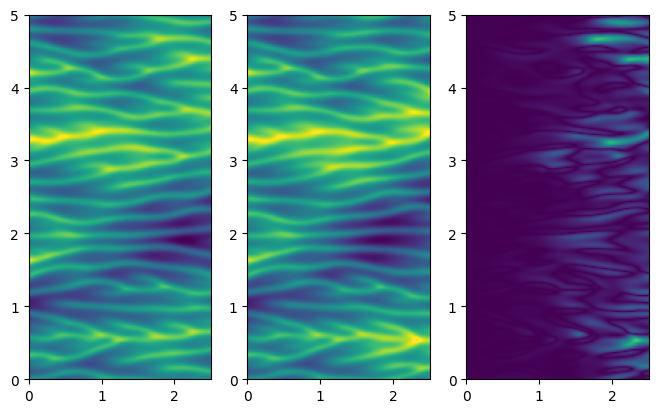

In [494]:
import numpy as np
%matplotlib inline
d = torch.tensor(np.load("ks1d_dimensionless.npy")).double()
d = normalize(d)

# This is really important. 
# I don't know why, but shenfun doesn't simulate the "true" KS equation in 2d but a version that keeps its mean at zero. 
# The 1d version I have simulated doesn't do that; its average value diverges.
# The following line takes the average value back to zero.
d = d - d.mean(dim=1)[:,None] 

D = d[-2:,:]
X, Y = D[0,None,:], D[1,None,:]
model = Model(bc=[BC_0, BC_1])
model.train(X - X.mean(), Y - X)

# plt.colorbar ( plt.imshow( d.T.cpu(), extent=[0,10,0,10]) )
# plt.show()
# 
# X, Y = d[8000,None,:], d[8001,None,:]
# 
# plt.plot( (f(X) - Y).flatten().cpu(), label="f(X) - Y" )
# # plt.plot( ( X + model(X) - Y ).flatten().cpu(), label="f(X)" )
# plt.plot(   (X - Y).flatten().cpu(), label="X - Y" )
# plt.legend()

# ---- comparison ----

# simulates the model for a few time steps and compares it to shenfuns prediction
N0 = 5000
d_new = torch.empty(d.shape[0]-N0,d.shape[1]).double()
d_new[0,:] =  d[N0,:]
for i in range(d.shape[0]-N0-1):
    d_new[i+1,:] = f(d_new[i,None,:])[0,:]

# plots
fig, ax = plt.subplots(1,3,figsize=(8,5))
ax[0].imshow(d_new.T.cpu(), extent=[0,2.5,0,5], vmin=-0.3, vmax=0.3)
ax[1].imshow(d[N0:].T.cpu(), extent=[0,2.5,0,5], vmin=-0.3, vmax=0.3)
ax[2].imshow((d[N0:]-d_new).abs().T.cpu(), extent=[0,2.5,0,5], vmin=0, vmax=0.5)
plt.show()

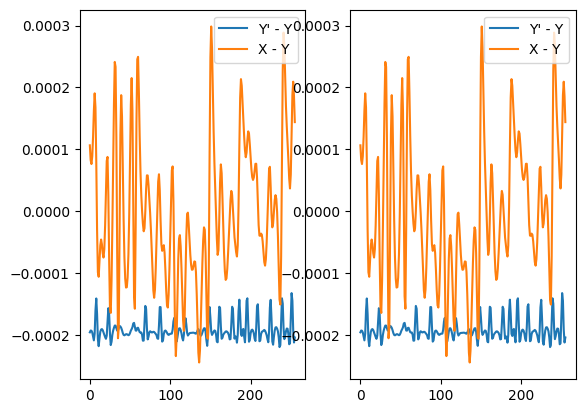

In [441]:
h = 60 * np.pi / 256
dt = 0.01
extent = 1

fig, ax = plt.subplots(1,2)

# completely one-dimensional
X_ = torch.cat((X[:,-2*extent:],X,X[:,:2*extent]),dim=1).unsqueeze(1)
X_ = denormalize(X_)
lap = torch.tensor([1,-2,1]).double().view(1,1,3) / h**2
id = torch.tensor([0,1,0]).double().view(1,1,3)
conv = torch.nn.functional.conv1d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
Y_ = denormalize(X) + dt * dX_
Y_ = Y_[:,0,:]
Y_ = normalize(Y_)
ax[0].plot(  (Y_ - Y).flatten().cpu(), label="Y' - Y" )
ax[0].plot(  (X - Y).flatten().cpu(), label="X - Y" )
ax[0].legend()

# two-dimensional
X_ = X_.unsqueeze(3).repeat(1,1,1,2*2*extent+1)
lap = torch.tensor([[1,2,1],[2,-12,2],[1,2,1]]).double().view(1,1,3,3) / h**2 / 4
id = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).double().view(1,1,3,3)
conv = torch.nn.functional.conv2d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
dX_ = dX_[:,0,:,0]
Y_ = denormalize(X) + dt * dX_
Y_ = normalize(Y_)
 
ax[1].plot(  (Y_ - Y).flatten().cpu(), label="Y' - Y" )
ax[1].plot(  (X - Y).flatten().cpu(), label="X - Y" )
ax[1].legend()

plt.show()

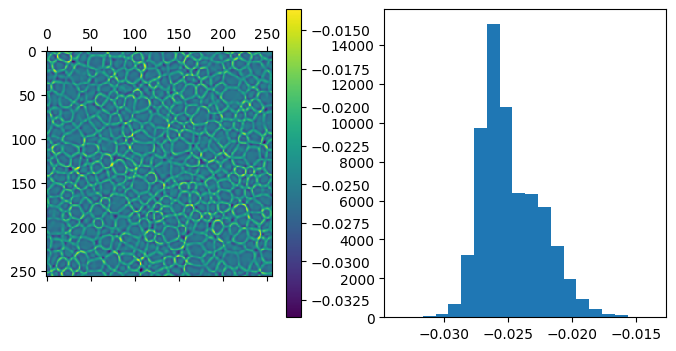

In [426]:

# this is very interesting: the finite-difference method comes with a *constant* bias 
# to the solution computed by shenfun ... which one is correct ?


D = torch.tensor(np.load("../ks2d/ks2d_short.npy"))
X, Y = D[0,None,None,...], D[1,None,None,...]

# two-dimensional
X_ = pad(pad(X, 2, 2), 3, 2)
lap = torch.tensor([[1,2,1],[2,-12,2],[1,2,1]]).double().view(1,1,3,3) / h**2 / 4
id = torch.tensor([[0,0,0],[0,1,0],[0,0,0]]).double().view(1,1,3,3)
conv = torch.nn.functional.conv2d
dX_ = - conv(conv(X_,lap),lap) - conv(conv(X_,lap),id) - 0.5 * ( 0.5 * conv(conv(X_**2,lap),id) - conv(conv(X_,id)*conv(X_,lap),id))
Y_ = X + dt * dX_

fig, ax = plt.subplots(1,2,figsize=(8,4))
plt.colorbar( ax[0].matshow((Y_-Y)[0,0,...].cpu().numpy()) )
ax[1].hist( (Y_-Y).flatten().cpu().numpy(), bins=20 )
plt.show()